In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from sklearn.metrics import accuracy_score


In [2]:
# =====================
# CONFIG
# =====================
IMG_SIZE = 224
BATCH_SIZE = 16

MODEL_PATH = r"C:\Users\adity\Downloads\student_kd_mobilenetv3small.keras"
TEST_DIR = r"C:\Users\adity\Downloads\dataset_split_final\test"


In [3]:
# =====================
# LOAD KD STUDENT MODEL
# =====================
student = tf.keras.models.load_model(
    MODEL_PATH,
    compile=False
)
print("✅ KD Student FP32 loaded")


✅ KD Student FP32 loaded


In [4]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = test_gen.num_classes
CLASS_NAMES = list(test_gen.class_indices.keys())

print("Classes:", CLASS_NAMES)


Found 1000 images belonging to 10 classes.
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(student)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# INT16 weights
converter.target_spec.supported_types = [tf.int16]

# Input & output tetap float (WAJIB)
converter.inference_input_type  = tf.float32
converter.inference_output_type = tf.float32

tflite_int16 = converter.convert()

with open("student_kd_int16.tflite", "wb") as f:
    f.write(tflite_int16)

print("✅ INT16 quantized model saved")


INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmp9wpp9ree\assets


INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmp9wpp9ree\assets


Saved artifact at 'C:\Users\adity\AppData\Local\Temp\tmp9wpp9ree'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2364487754064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487754640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487755216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487755600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487754832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487753872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487757520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487756368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487756752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2364487756176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23644

In [7]:
fp32_size  = os.path.getsize(MODEL_PATH) / (1024 * 1024)
int16_size = os.path.getsize("student_kd_int16.tflite") / (1024 * 1024)

print("\n📦 MODEL SIZE")
print(f"FP32  : {fp32_size:.2f} MB")
print(f"INT16 : {int16_size:.2f} MB")
print(f"Reduction : {(1 - int16_size/fp32_size)*100:.2f}%")



📦 MODEL SIZE
FP32  : 4.40 MB
INT16 : 3.84 MB
Reduction : 12.84%


In [8]:
interpreter = tf.lite.Interpreter(
    model_path="student_kd_int16.tflite"
)
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input dtype :", input_details[0]["dtype"])
print("Output dtype:", output_details[0]["dtype"])


Input dtype : <class 'numpy.float32'>
Output dtype: <class 'numpy.float32'>


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [9]:
y_true = []
y_pred = []

start = time.time()

test_gen.reset()
for i in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)

    for j in range(x_batch.shape[0]):
        interpreter.set_tensor(
            input_details[0]["index"],
            x_batch[j:j+1].astype(np.float32)
        )
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]["index"])

        y_true.append(np.argmax(y_batch[j]))
        y_pred.append(np.argmax(output))

total_time = time.time() - start
avg_infer = total_time / len(y_true)
fps = 1 / avg_infer


In [10]:
from sklearn.metrics import accuracy_score

acc_fp16 = accuracy_score(y_true, y_pred)

print("\n✅ FP16 TEST RESULTS")
print(f"Accuracy        : {acc_fp16*100:.2f}%")
print(f"Avg infer/image : {avg_infer:.6f} sec")
print(f"FPS             : {fps:.2f}")



✅ FP16 TEST RESULTS
Accuracy        : 99.20%
Avg infer/image : 0.003421 sec
FPS             : 292.27


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)


In [12]:
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec  = recall_score(y_true, y_pred, average="weighted")
f1   = f1_score(y_true, y_pred, average="weighted")
cm = confusion_matrix(y_true, y_pred)



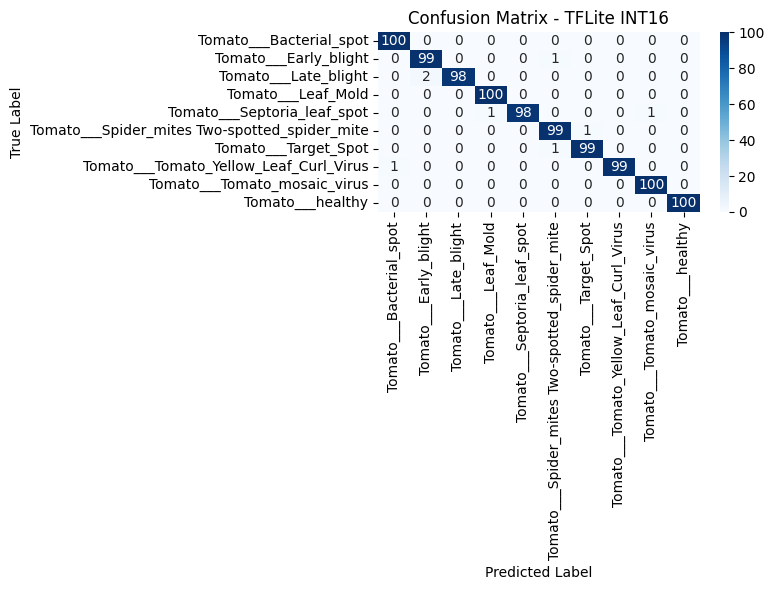

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TFLite INT16")
plt.tight_layout()
plt.show()


In [14]:
print("\n📑 Classification Report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=CLASS_NAMES,
        digits=4
    )
)



📑 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     0.9901    1.0000    0.9950       100
                        Tomato___Early_blight     0.9802    0.9900    0.9851       100
                         Tomato___Late_blight     1.0000    0.9800    0.9899       100
                           Tomato___Leaf_Mold     0.9901    1.0000    0.9950       100
                  Tomato___Septoria_leaf_spot     1.0000    0.9800    0.9899       100
Tomato___Spider_mites Two-spotted_spider_mite     0.9802    0.9900    0.9851       100
                         Tomato___Target_Spot     0.9900    0.9900    0.9900       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     1.0000    0.9900    0.9950       100
                 Tomato___Tomato_mosaic_virus     0.9901    1.0000    0.9950       100
                             Tomato___healthy     1.0000    1.0000    1.0000       100

               